In [1]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report


# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model


# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model

# Audio
import librosa.display, librosa

Using TensorFlow backend.
/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rutherford/.local/lib/python3.6/site-packages/t

# Get filenames

In [2]:
# Get files in data path
path='BirdSound2/'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 100 audio files in BirdSound2/


# Prepare labels from filenames

In [3]:
# Get Labels
labels =[]
classes=['Avocet','Coot','Crake','Crane', 'Dove','Gallinule', 
         'Grebe','Grouse','Lapwing','Nightjar']

color_dict={'Avocet':'blue','Coot':'magenta','Crake':'magenta','Crane':'magenta', 'Dove':'magenta',
         'Gallinule':'magenta','Grebe':'magenta','Grouse':'magenta','Lapwing':'magenta','Nightjar':'magenta',
         }

color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

# Encoded Labels

In [5]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

10 classes: Avocet, Coot, Crake, Crane, Dove, Gallinule, Grebe, Grouse, Lapwing, Nightjar


In [ ]:
print('Labels:', labels[:3])
print('Encoded Classes: ', classes_num[0:3])

# Parameters

In [6]:
# Signal Processing Parameters
fs = 22050        # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frame
n_mels = 128       # Number of Mel bands        
# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

# Feature Extraction

In [7]:
#y, sr = librosa.load(librosa.util.example_audio_file())
#librosa.feature.melspectrogram(y=y, sr=sr)

In [10]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    melspectrogram = librosa.feature.melspectrogram(y, sr=fs)
    feature_vector = np.mean(melspectrogram,1)
    return feature_vector

# Load audio files, calculate features and create feature vectors

In [11]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 100 = BirdSound2/Gallinule/XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav
get 2 of 100 = BirdSound2/Gallinule/XC414334 - Common Gallinule - Gallinula galeata.wav
get 3 of 100 = BirdSound2/Gallinule/XC246282 - Common Gallinule - Gallinula galeata.wav
get 4 of 100 = BirdSound2/Gallinule/XC384693 - Common Gallinule - Gallinula galeata.wav
get 5 of 100 = BirdSound2/Gallinule/XC51100 - Purple Gallinule - Porphyrio martinica.wav
get 6 of 100 = BirdSound2/Gallinule/XC264307 - Purple Gallinule - Porphyrio martinica.wav
get 7 of 100 = BirdSound2/Gallinule/XC50276 - Spot-flanked Gallinule - Porphyriops melanops.wav
get 8 of 100 = BirdSound2/Gallinule/XC223347 - Common Gallinule - Gallinula galeata.wav
get 9 of 100 = BirdSound2/Gallinule/XC1147 - Purple Gallinule - Porphyrio martinica.wav
get 10 of 100 = BirdSound2/Gallinule/XC228563 - Purple Gallinule - Porphyrio martinica.wav
get 11 of 100 = BirdSound2/Grouse/XC320022 - Dusky Grouse - Dendragapus obscurus.wav
get 12 of 100

get 97 of 100 = BirdSound2/Nightjar/XC197450 - Lyre-tailed Nightjar - Uropsalis lyra.wav
get 98 of 100 = BirdSound2/Nightjar/XC180595 - Band-winged Nightjar - Systellura longirostris.wav
get 99 of 100 = BirdSound2/Nightjar/XC212331 - Standard-winged Nightjar - Caprimulgus longipennis.wav
get 100 of 100 = BirdSound2/Nightjar/XC290528 - Malaysian Eared Nightjar - Lyncornis temminckii.wav
Calculated 100 feature vectors


# Standardization: Zero-Mean and Unit-Variance

In [12]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (100, 128)


# Train and Test Sets

In [13]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [14]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (75, 128)
test_set shape: (25, 128)
train_classes shape: (75,)
test_classes shape: (25,)


# Keras

In [15]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

# One Hot Encoding

In [16]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [ ]:
print('Integer Encoded:', integer_encoded_train_classes[:3] )
print('One-hot Encoded: ', onehot_encoded_train_classes[:3] )

In [17]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",test_set_d.shape)
print("train_classes shape:",onehot_encoded_train_classes.shape)
print("test_classes shape:",onehot_encoded_test_classes.shape)

train_set shape: (75, 128)
test_set shape: (25, 128)
train_classes shape: (75, 10)
test_classes shape: (25, 10)


In [18]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [19]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (75, 1, 128)
test_set shape: (75, 1, 128)
train_classes shape: (75, 1, 10)
test_classes shape: (25, 1, 10)


# Create a Model

In [20]:
# Creat Simple Model
model_input = Input(shape=(1,train_set.shape[1]))
fc1 = Dense(70, activation="relu")(model_input)
fc2 = Dense(60, activation="relu")(fc1)
fc3 = Dense(50, activation="relu")(fc2)
fc4 = Dense(40, activation="relu")(fc3)
fc5 = Dense(30, activation="relu")(fc4)
fc6 = Dense(20, activation="relu")(fc5)
n=onehot_encoded_train_classes.shape[1]
out = Dense(n, activation="softmax")(fc4)
model_d = Model(inputs=[model_input], outputs=[out])
model_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 70)             9030      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 60)             4260      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 50)             3050      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 40)             2040      
_________________________________________________________________
dense_7 (Dense)              (None, 1, 10)             410       
Total params: 18,790
Trainable params: 18,790
Non-trainable params: 0
_______________________________________________________

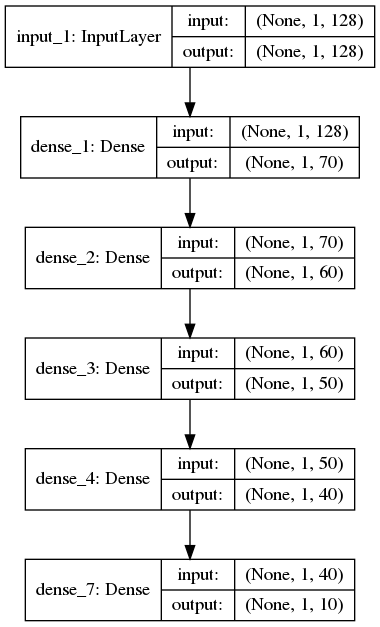

In [21]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
keras.utils.plot_model(model_d, to_file='model.png', show_shapes=True)

# Compile a Model

In [22]:
# Compile Model
model_d.compile(loss      = 'categorical_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   =['accuracy'])

# Train a Model

In [23]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 200    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = model_d.fit(train_set_d, train_classes_d_hot, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set_d,test_classes_d_hot))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 75 samples, validate on 25 samples
Epoch 1/200
75/75 [==============================] - 1s 13ms/step - loss: 2.3450 - accuracy: 0.1067 - val_loss: 2.3584 - val_accuracy: 0.1600
Epoch 2/200
75/75 [==============================] - 0s 608us/step - loss: 2.1624 - accuracy: 0.2667 - val_loss: 2.2902 - val_accuracy: 0.2800
Epoch 3/200
75/75 [==============================] - 0s 562us/step - loss: 1.9902 - accuracy: 0.4400 - val_loss: 2.2197 - val_accuracy: 0.2800
Epoch 4/200
75/75 [==============================] - 0s 680us/step - loss: 1.8097 - accuracy: 0.5333 - val_loss: 2.1729 - val_accuracy: 0.2800
Epoch 5/200
75/75 [==============================] - 0s 596us/step - loss: 1.6111 - accuracy: 0.5200 - val_loss: 2.1154 - val_accuracy: 0.2800
Epoch 6/200
75/75 [==============================] - 0s 540us/step - loss: 1.4305 - accuracy: 0.6533 - val_loss: 2.1188 - val_accuracy: 0.3600
Epoc

Epoch 110/200
75/75 [==============================] - 0s 675us/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 5.1247 - val_accuracy: 0.3600
Epoch 111/200
75/75 [==============================] - 0s 519us/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 5.0318 - val_accuracy: 0.4000
Epoch 112/200
75/75 [==============================] - 0s 605us/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 5.1788 - val_accuracy: 0.3600
Epoch 113/200
75/75 [==============================] - 0s 639us/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 5.0139 - val_accuracy: 0.2800
Epoch 114/200
75/75 [==============================] - 0s 584us/step - loss: 0.0435 - accuracy: 0.9733 - val_loss: 5.0518 - val_accuracy: 0.3200
Epoch 115/200
75/75 [==============================] - 0s 533us/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 5.3340 - val_accuracy: 0.4000
Epoch 116/200
75/75 [==============================] - 0s 568us/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 5.4750 - val_ac

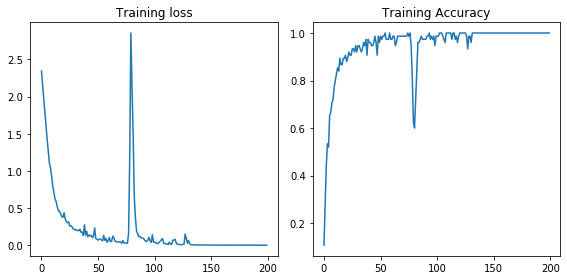

In [24]:
# Plot Training Loss and Training Accuracy
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Training loss")
plt.plot(range(epochs),hist.history["loss"])

plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(range(epochs),hist.history["accuracy"])

plt.tight_layout()

# Make Predictions

In [25]:
# Predict
predictions = model_d.predict(test_set_d)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=2)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

# Evaluation

In [26]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_num[test_index], predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_num[test_index], predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_num[test_index], predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_num[test_index], predictions_int,normalize=True), accuracy_score(classes_num[test_index], predictions_int,normalize=False) )
print("Number of samples:",classes_num[test_index].shape[0])

print(classification_report(classes_num[test_index], predictions_int))

Recall:  [0.66666667 0.5        0.5        0.66666667 0.         0.33333333
 0.         0.33333333 0.5        0.5       ]
Precision:  [0.33333333 0.2        0.25       1.         0.         0.5
 0.         1.         0.5        0.33333333]
F1-Score:  [0.44444444 0.28571429 0.33333333 0.8        0.         0.4
 0.         0.5        0.5        0.4       ]
Accuracy: 0.40  , 10
Number of samples: 25
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.20      0.50      0.29         2
           2       0.25      0.50      0.33         2
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         2
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         3
           7       1.00      0.33      0.50         3
           8       0.50      0.50      0.50         2
           9       0.33      0.50      0.40         2

    

/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

In [28]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

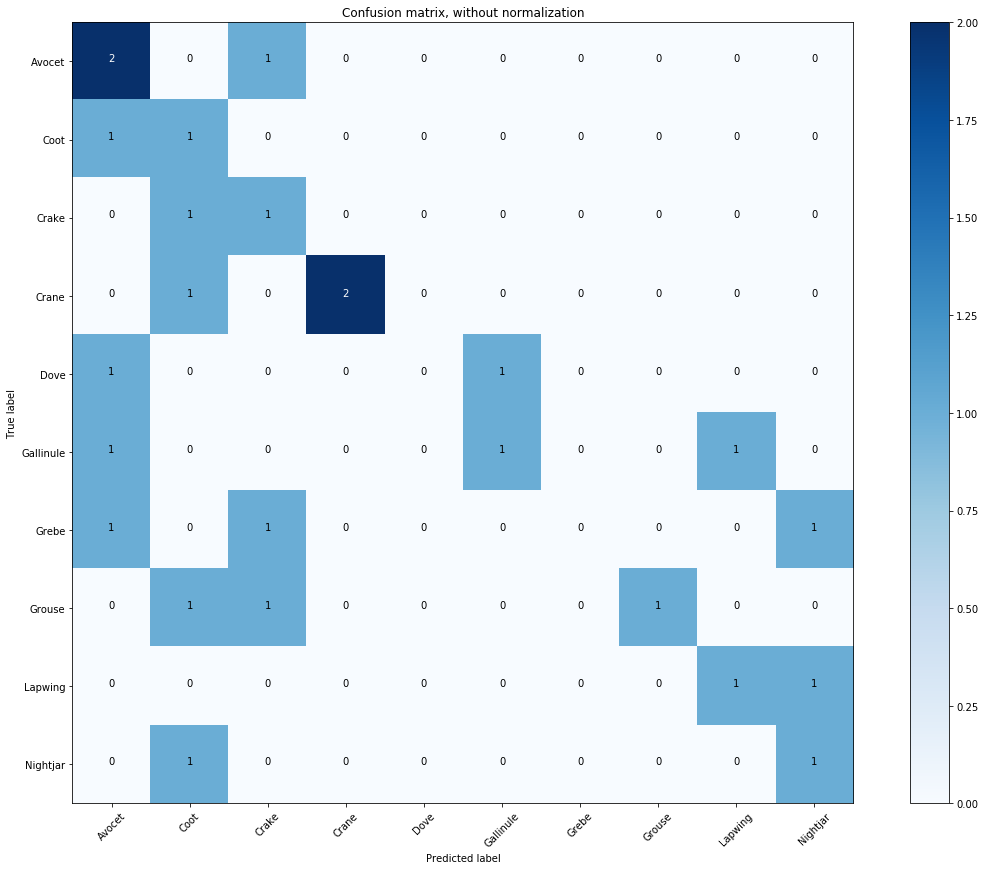

In [29]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [30]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predictions_int)) if e1 != e2]

In [31]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['Dove' 'Dove' 'Nightjar' 'Grebe' 'Grebe' 'Grebe' 'Crane' 'Gallinule'
 'Grouse' 'Gallinule' 'Crake' 'Coot' 'Avocet' 'Grouse' 'Lapwing']
['Avocet' 'Gallinule' 'Coot' 'Nightjar' 'Avocet' 'Crake' 'Coot' 'Lapwing'
 'Crake' 'Avocet' 'Coot' 'Avocet' 'Crake' 'Coot' 'Nightjar']
['BirdSound2/Dove/XC45718 - Namaqua Dove - Oena capensis.wav'
 'BirdSound2/Dove/XC277489 - European Turtle Dove - Streptopelia turtur.wav'
 'BirdSound2/Nightjar/XC167119 - Rufous Nightjar - Antrostomus rufus.wav'
 'BirdSound2/Grebe/XC331144 - Black-necked Grebe - Podiceps nigricollis.wav'
 'BirdSound2/Grebe/XC377189 - Little Grebe - Tachybaptus ruficollis.wav'
 'BirdSound2/Grebe/XC466329 - Little Grebe - Tachybaptus ruficollis.wav'
 'BirdSound2/Crane/XC459728 - Common Crane - Grus grus.wav'
 'BirdSound2/Gallinule/XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav'
 'BirdSound2/Grouse/XC90846 - Black Grouse - Lyrurus tetrix tetrix.wav'
 'BirdSound2/Gallinule/XC228563 - Purple Gallinule - Porphyrio martinica.wav'